In [1]:
set.seed(123)
par(mar = c(4,4,1,1))
nSamples <- 250
height<-rnorm(nSamples, 180, 20)
sex<-as.factor(sample(c("male", "female"), size = nSamples, replace = TRUE, prob = c(0.45,0.55)))
height<-height + rnorm(nSamples, 10,5)*(as.numeric(sex)-1)
age<-floor(runif(nSamples, 40,60))
weight<- height * 0.7 - 44 + rnorm(nSamples,0,12)

weight<-weight + rnorm(nSamples, 3, 2)*(as.numeric(sex)-1) + rnorm(nSamples, 0.005, 0.001)*(as.numeric(sex)-1) * height
weight <- weight + age * rnorm(nSamples, 0.04, 0.03)
bmi <- weight/(height/100)^2

smoker<-sample(c(0,1), size = nSamples, replace = TRUE, prob = c(0.8,0.2))
t2diabetes <- sample(c(0,1), size = nSamples, replace = TRUE, prob = c(0.8,0.2))
t2diabetes[sample(which(bmi > 25),10)]<-1
t2diabetes[sample(which(smoker == 1),5)]<-1

exercise_hours <- rpois(nSamples, 1) + rpois(nSamples, 2)*(1-t2diabetes) + rpois(nSamples, 1) * (as.numeric(sex)-1)
alcohol_units <- rpois(nSamples, 3) + rpois(nSamples, 5)*(1-t2diabetes) + rpois(nSamples, 3) * (as.numeric(sex)-1) + rpois(nSamples, 1)*rpois(nSamples, 6)*(1-t2diabetes) 
exercise_hours[which(weight < 60)]<-rpois(sum(weight < 60), 12)
alcohol_units[which(bmi > 37)]<-alcohol_units[which(bmi > 37)] + rpois(sum(bmi > 37),5)
alcohol_units[which(weight > 140)]<-rpois(sum(weight > 140),50)

ethnicity<-sample(c("European", "Asian", "AfricanAmerican"), nSamples, replace = TRUE, prob = c(0.6,0.25,0.15))
socioeconomic_status <- sample(c("High", "Middle", "Low"), nSamples, replace = TRUE, prob = c(0.25,0.5,0.25))
socioeconomic_status[which(bmi > 25)] <- sample(c("High", "Middle", "Low"), sum(bmi > 25), replace = TRUE, prob = c(0.1,0.25,0.65))

demoDat <-data.frame(age, height, weight, bmi, ethnicity, socioeconomic_status, smoker, exercise_hours, alcohol_units, t2diabetes)

# Hypothesis Testing for Regression Models

If you have run regression models in other software or have seen the results of regression analysis presented in scientific reports, you might be wondering where the p-values are. Don't worry - they are there. Before we look at how you go about extracting this information, we will first go over how hypothesis testing works in the context of regression.

## Learning Objectives 
- Learn the foundational concepts of hypothesis testing within the context of regression analysis, including null and alternative hypotheses.
- Identify the key statistical assumptions required for hypothesis testing in regression and understand their significance.
- Gain proficiency in using R functions such as `lm()` and `summary()` to perform hypothesis tests on regression coefficients.
- Learn to interpret the output of regression models, including coefficients, standard errors, t-values, and p-values.
- Develop skills to check and validate the assumptions of linear regression using diagnostic plots and statistical tests. 

## The Theory

Recall how the relationship between X and Y can be written down as a mathematical equation: 

$$Y = \theta_{0}  + \theta_{1} X$$

The important parameter for understanding the relationship between X and Y is $\theta_1$. Specifically the magnitude of $\theta_1$ tells us about the strength of the relationship between X and Y. When we looked at the different lines you could get by changing the values of $\theta_0$ and $\theta_1$ there were two very specific scenarios we didn't consider, when either $\theta_0 = 0$ or $\theta_1 = 0$. Let's see what happens to our equation in these situations:

If $\theta_0 = 0$ then our equation becomes

$$Y = 0  + \theta_{1} X = \theta_{1}X$$

Recall that the intercept is the position on the y-axis when the line crosses. If $\theta_0 = 0$ then our line will cross the y-axis through the origin (i.e  the point (0,0)). 


If $\theta_1 = 0$ then our equation becomes

$$Y = \theta_0  + 0 X = \theta_{0}$$

When you multiply anything by zero, the answer is always 0. If the coefficient for our X variable is 0, regardless of what the value of X is, this will compute to 0. We can simplify our prediction equation and remove the X term from the equation. Our predictive equation for Y is no longer dependent on or influenced by the predictor variable X.

This is essentially saying that there is no relationship between X and Y. This is the concept that underlies hypothesis testing in regression analysis. If there is a relationship between X and Y the regression parameter for X needs to be non-zero. If it is non-zero, then the value of X will have some effect of the prediction of Y, albeit it potentially quite small, but an effect none the less. 


To statistically test for an effect we require an explicitly stated null hypothesis and alternative hypothesis. We will then use our observed data to summarise the evidence to determine if there is enough evidence to reject the null hypothesis in favour of the alternative. For each individual regression coefficient these are:

$$H_{null}: \theta = 0$$
$$H_{alternative}: \theta \neq 0$$
To test these hypotheses with the observed data we implement the following steps:

1. accumulate the evidence from the data
2. use a statistical theory or the data to establish how normal/extreme this result is
3. apply some criteria to draw a conclusion in the context of the proposed hypotheses


We have already started to accumulate the evidence by estimating the values of the regression coefficient. This estimate is then converted into a t-statistic (by dividing by the estimated standard error) which enables us to use a known statistical distribution to quantify how likely it is to occur. The relevant distribution here is the Student's t-distribution. With this knowledge we can then calculate a p-value which we used to decide which hypothesis our data favours. You might recognise this distribution, if you are familar with t-tests. Hold this thought, we will revist this later.



## Statistical Assumptions

To enable us to complete this process, we have made a series of assumptions about the data. If these do not hold true, this process potentially falls apart. So understanding the context within which hypothesis testing has been formulated is important for deriving accurate and meaningful statistical inference.

For hypothesis testing of a regression coefficient for X, the assumptions are:

* The dependent variable Y has a linear relationship to the independent variable X.
* Errors (residuals) are normally distributed.
* Samples are independent.
* Variances in each group are equal.

Let's revisit our R code to see how we can extract this information for our regression model. 

## Hypothesis Testing of Regression Parameters in R 

We don't actually need to get R to do any further calculations to get the p-values for our statistical hypothesis testing. This is done when you execute `lm()`. By default though it does not print the output to console. We do need to use some additional commands to extract this information. This is largely achieved with the  `summary()` function. We could chain these commands together i.e. `summary(lm()))` or we could save the output of `lm()` to a variable and run it as two lines of code as shown below:

In [2]:
model<-lm(weight ~ height, data = demoDat)
summary(model)


Call:
lm(formula = weight ~ height, data = demoDat)

Residuals:
    Min      1Q  Median      3Q     Max 
-33.487  -8.135   0.541   7.116  35.621 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) -39.52197    7.54114  -5.241 3.42e-07 ***
height        0.69876    0.04063  17.197  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 12.51 on 248 degrees of freedom
Multiple R-squared:  0.5439,	Adjusted R-squared:  0.5421 
F-statistic: 295.7 on 1 and 248 DF,  p-value: < 2.2e-16


We can see that the `summary()` function expands on the information printed to the console compared to just running `lm()`.

From top to bottom, we have:

* the model formula
* a summary of the residuals (i.e errors)
* a table of coefficients
* model fit statistics. 


We are probably most interested in the coefficients table which contains a summary of each estimated regression coefficient. The results for each coefficient are provided in separate rows, with the intercept in the top row followed by 1 row for each explanatory variable and 4 columns. It is worth noting at this point that the intercept is also a regression coefficient which we can test. However, we almost never consider this result as 

1. it is virtually always significantly non-zero 

and

2. it doesn't tell us anything about relationships between variables  

The columns in the coefficients table are as follows:

| Column | Content |
|-------|------|
| Estimate | estimated regression coefficient | 
| Std. Error | standard error of the estimated regression coefficient |
| t value | The test statistic (the ratio of the previous two columns) | 
| Pr(> t) | P-value comparing the t value to the Student's t distribution | 

We can also see from the coefficients table above that the slope parameter has a p-value < 0.05. Therefore, we can conclude that it is significantly non-zero and reject the null hypothesis in favour of the alternative hypothesis. There is a statistically significant relationship between height and weight in this dataset.


We can visualise this estimated model, by generating a scatterplot of the observed data and adding the fitted regression line to the plot. 


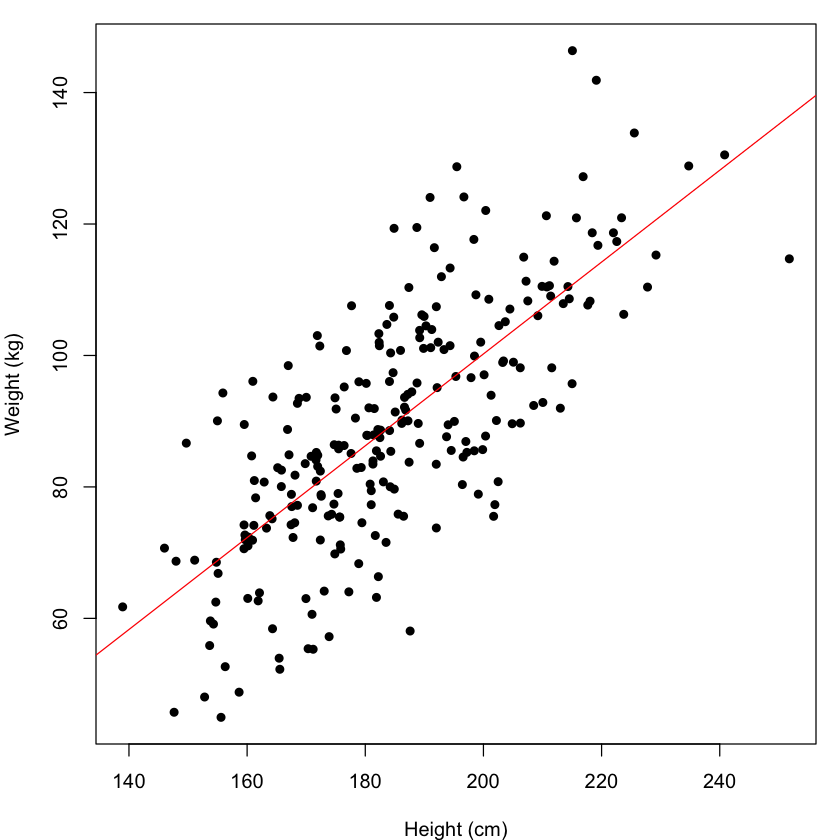

In [3]:
par(mar = c(4,4,1,1))
plot(demoDat$height, demoDat$weight, pch = 16, xlab = "Height (cm)", ylab = "Weight (kg)")
abline(model, col = "red")

We can see the positively correlated relationship between height and weight. The fitted regression model appears to represent the data well but there is some noise around the fitted line. In other words the model is not perfect. Potentially there are other factors that could improve the prediction further.  



## Hypothesis Testing of Regression Coefficients Exercise 

*Let's see if age has a significant effect on weight.*

Write the R code required, to test using a regression model, the following: 

1. Is weight significantly associated with age?
2. Is BMI significantly associated with age?

```{admonition} Solution
:class: dropdown
``` R
model1<-lm(weight ~ age, data = demoDat)
summary(model1)

model2<-lm(bmi ~ age, data = demoDat)
summary(model2)
```
```

In [4]:
# Call the function to display quiz interactively:
source("../../R_functions/quiz_renderer.R")
show_quiz_from_json("questions/hypothesis_testing.json")

Which of these statements are true for the relationship between weight and age? Apply a significance threshold of 0.05. 
 The intercept is significantly non-zero 
 Age is significantly associated with weight 
 
 Submit
 
 Which of these statements are true for the relationship between BMI and age? Apply a significance threshold of 0.05. 
 The intercept is significantly non-zero 
 BMI is significantly associated with weight. 
 
 Submit

## Checking the Assumptions of Linear Regression

As we mentioned before, by making assumptions about the characteristics of our data, we can do significance testing. It is prudent, therefore, to check whether these assumptions hold true so that we can be confident in the conclusion we have deduced. However, this is far from common practice. There are a number of reasons why. 

Firstly, the assumptions are to some degree subjective and assessing them is not an exact science. It can be hard to know what to look for if you don't have much experience in fitting regression models. The underlying mathematics of regression is robust to some deviation from these assumptions. So there is some tolerence around these we can allow. Common tools to assess properties like Normality might not place the threshold for deviation in the same place as the statistical model needs. Often they are more conservative and therefore you might prematurely reject a valid result. 

Secondly, (and perhaps most pertinent), it is not possible to check many of the assumptions without fitting the model first. Therefore, you run the risk that if you find a significant effect, you get excited and forget to check the assumptions in favour of pursuing a more exciting follow-up question. However, as the assumptions are essential for deriving the formula to estimate and test the regression parameters, if they are violated, we need to be cautious about accepting the results, especially if they are significant.

Functionality to do this is provided within R. We can easily generate 4 plots, where we can visually inspect some of the assumptions of linear regression by applying the `plot()` function to the output of an `lm()` call. We can see these plots for the height and weight examples from above.


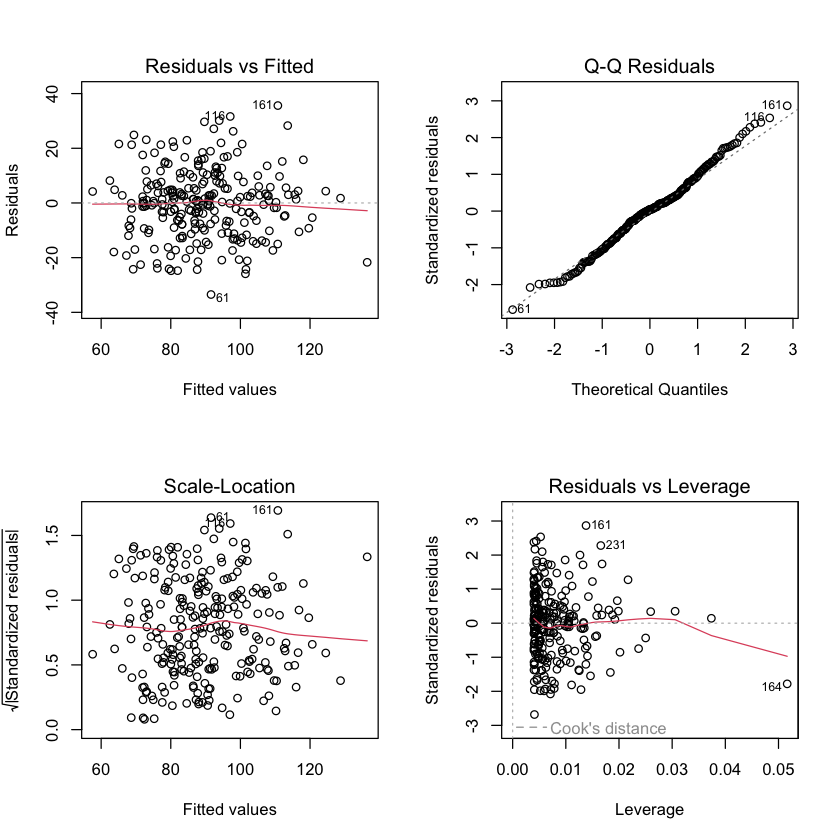

In [5]:
model<- lm(weight ~ height, data = demoDat)
par(mfrow = c(2,2))
plot(model)

Decisions on the validity of the results are then given by assessing these plots. Below we outline what is good and bad.

### Plot 1: Residuals vs Fitted

Do the residuals show a non-linear pattern?  

**Good:**   

* no evidence of a relationship between these variables. (i.e. equal number of points above and 	below the line or a random scatter)

**Bad:**   

* a pattern in the points – may be indicative of a non-linear relationship between your outcome and independent variables. 
	
### Plot 2: Normal Q-Q

Are the residuals normally distributed?  

**Good:**  

* the points follow the dotted diagonal line

**Bad:**  

* the points deviate from the dotted diagonal line.

### Plot 3: Scale-Location

Are the residuals equally spread across the range of predictions?  

**Good:**  

* horizontal line with no evidence of a relationship between these variables	

**Bad:**  

* a non horizontal line and more/less points in one corner of the plot, may indicate heteroscedasticity.
	
### Plot 4: Residuals vs Leverage

Are any samples overly influencing the fit?  

**Good:**   

* all inside red dashed line

**Bad:**  

* any values in the upper right or lower right corner or cases outside of a dashed red line, indicates samples that don’t fit the trend in the data and are biasing the result.

As these require a subjective assessment of the plots, it can be difficult to decide whether the plot looks good or bad. This is particularly challenging where the data has only a small number of observations. We should also bear in mind that linear regression is fairly robust to the violation of many of the assumptions. Therefore, even if the plots don't look ideal, that does not automatically mean that the result is invalid. This is where statistics moves away from a fixed quantity and into a gray area of subjectivity. Experience is the only real aid here, the more regression models you fit and the more plots you look at enables you to gauge what is a major or minor deviation. 

For contrast, let's fit another linear model where the assumptions might not hold true. Let's look at the relationship between weight and hours exercised per week (`exercise_hours`). When we asked the participants how much exercise they did each week they were effectively counting the number of hours, so this variable is a count variable. Count varibles are typically Poisson distributed and are limited to whole, positive numbers, so not a continuous variable and therefore potentially violating one of our assumptions.   


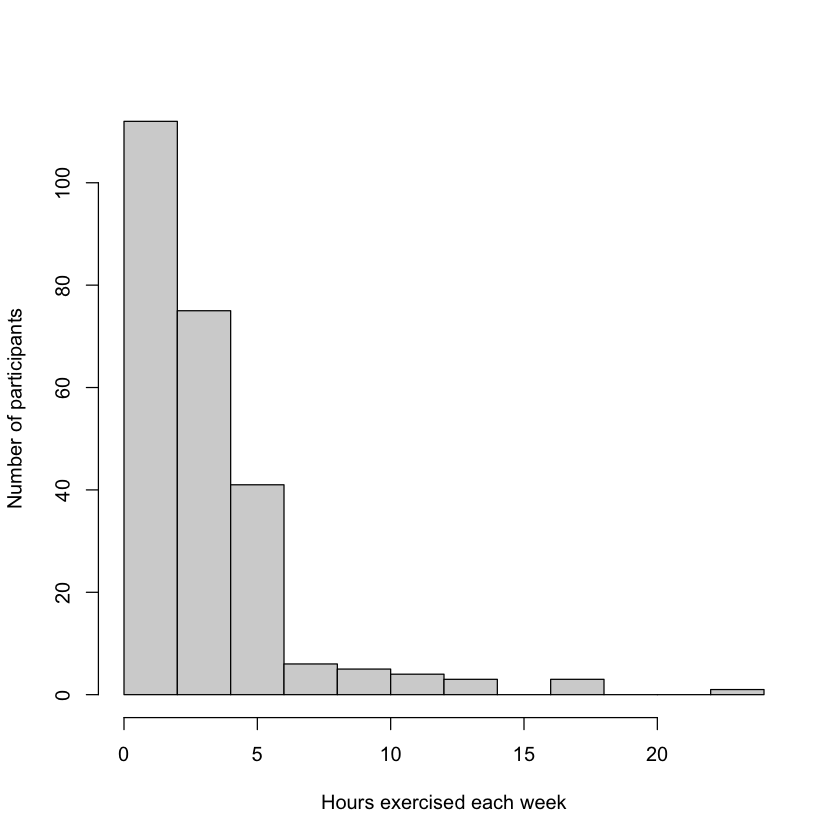

In [6]:
hist(demoDat$exercise_hours, xlab = "Hours exercised each week", ylab = "Number of participants", main = "")

In the histogram above we can see a non-symetrical distribution with a hard boundary of 0 on the left and a long tail on the right hand side. 
Let's take a look at what happens if we use it as a predictor variable against weight. 



Call:
lm(formula = weight ~ exercise_hours, data = demoDat)

Residuals:
    Min      1Q  Median      3Q     Max 
-36.237 -13.008  -1.706  10.832  62.103 

Coefficients:
               Estimate Std. Error t value Pr(>|t|)    
(Intercept)     96.5191     1.6185   59.64  < 2e-16 ***
exercise_hours  -2.0414     0.3437   -5.94  9.6e-09 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 17.34 on 248 degrees of freedom
Multiple R-squared:  0.1245,	Adjusted R-squared:  0.121 
F-statistic: 35.28 on 1 and 248 DF,  p-value: 9.601e-09


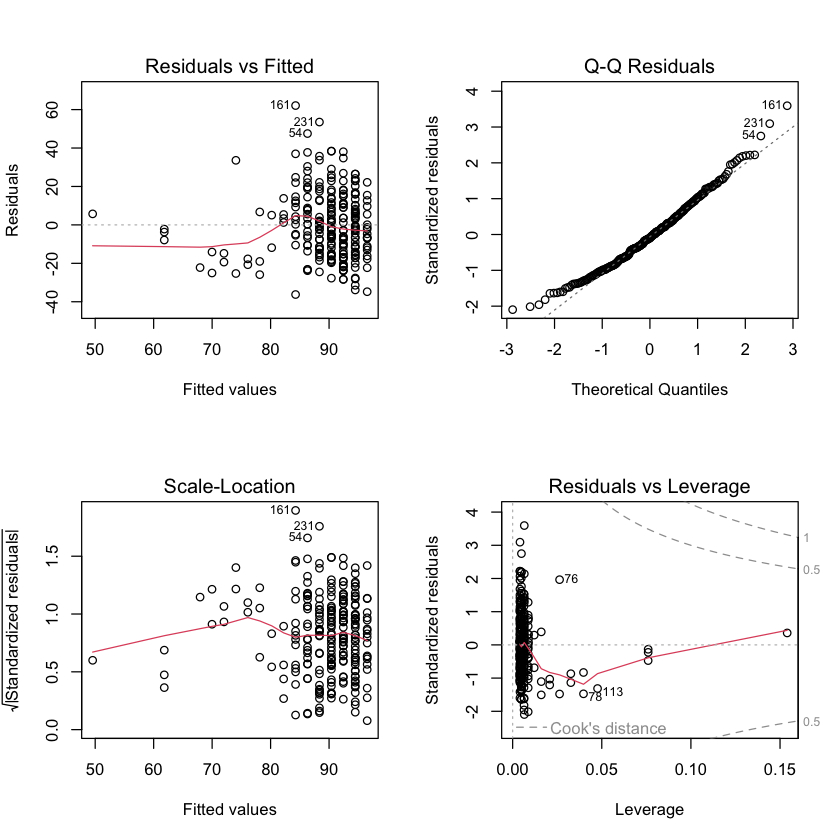

In [7]:
summary(lm(weight ~ exercise_hours, data  = demoDat))
par(mfrow = c(2,2))
plot(lm(weight ~ exercise_hours, data  = demoDat))

**Plot 1: Residuals vs Fitted** We can see vertical lines of dots which is a reflection of the fact the observed X variable only contains whole numbers. On the right hand side the points appear reasonably random in the space, but perhaps some bias to the left hand side. 

**Plot 2: Normal QQ** Points largely on the diagonal line in the centre of the distribution, but some deviation at both extremes.

**Plot 3: Scale-Location** We see the vertical lines again and more points of the right-hand side. Possibly some weird empty spaces, where points are absent on the left-hand side. 

**Plot 4: Residuals vs Leverage** There are some samples with extreme values (on the far right) not quite in line with the rest of the points, but not outside the accepted region.  

So, in conclusion, we can see less desirable behaviour of our observed data as we try to force a discrete variable into a methodology for a continuous variable. 



## Inspecting the Assumptions Exercise 

*Let's have a go at creating and interpretting some diagnostic plots.*

Write the R code required to determine if a regression model is an appropriate tool for assessing the relationship between:

1. age and weight
2. bmi and avearage number of alcohol units drunk per week (`alcohol_units`)


```{admonition} Solution
:class: dropdown
``` R
summary(lm(weight ~ age, data = demoDat))
plot(lm(weight ~ age, data = demoDat))
summary(lm(bmi ~ alcohol_units, data = demoDat))
plot(lm(bmi ~ alcohol_units, data = demoDat))
```
```

In [8]:
# Call the function to display quiz interactively:
source("../../R_functions/quiz_renderer.R")
show_quiz_from_json("questions/summary_hypothesis_testing.json")

What does the null hypothesis (HO) state in the context of regression analysis? 
 There is a significant relationship between X and Y 
 The coefficient of X is zero 
 The coefficient of Y is greater than zero 
 The residuals are normally distributed 
 
 Submit
 
 Which assumption is NOT required for hypothesis testing in regression analysis? 
 Errors (residuals) are normally distributed 
 Samples are dependent 
 Variances in each group are equal 
 The dependent variable Y has a linear relationship with the independent variable X 
 
 Submit
 
 What does a p-value less than 0.05 indicate in the context of regression analysis? 
 The null hypothesis cannot be rejected 
 There is no significant relationship between the variables 
 The regression coefficient is significantly different from zero 
 The residuals are not normally distributed 
 
 Submit